# Sentiment Analysis project in Python


# Read Data and NLTK Basics

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [4]:
# Read in data
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data cleaning and Preprocessing

In [7]:
#Replace missing summaries with "No Summary" and drop rows with missing critical values
df['Summary'] = df['Summary'].fillna("No Summary")
df.dropna(subset=['Text'], inplace=True)

In [8]:
#Remove Duplicates
df = df.drop_duplicates(subset=['ProductId', 'UserId', 'Text'])

In [9]:
#remove rows with HelpfulnessDenominator = 0
df = df[df['HelpfulnessDenominator'] != 0]

In [10]:
df['Helpfulness_Ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']

# Custom Model

In [54]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
lemmatizer = WordNetLemmatizer()

# Download stopwords if not already available
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Define preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    # Lemmatize
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

df['Cleaned_Summary'] = df['Summary'].apply(preprocess_text)
df['Cleaned_Text'] = df['Text'].apply(preprocess_text)

# Step 6: Encode Labels (Convert Score to Sentiment Labels)
def encode_sentiment(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Score'].apply(encode_sentiment)

# Step 7: Normalize Numerical Columns
scaler = MinMaxScaler()
df['Normalized_Helpfulness'] = scaler.fit_transform(df[['Helpfulness_Ratio']])

# Save cleaned dataset (optional)
df.to_csv("cleaned_dataset.csv", index=False)

# Display cleaned dataset
print(df.head())

    Id   ProductId          UserId                      ProfileName  \
0    1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
2    3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3    4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
8    9  B000E7L2R4  A1MZYO9TZK0BBI                         R. James   
10  11  B0001PB9FE  A3HDKO7OW0QNK4                     Canadian Fan   

    HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                      1                       1      5  1303862400   
2                      1                       1      4  1219017600   
3                      3                       3      2  1307923200   
8                      1                       1      5  1322006400   
10                     1                       1      5  1107820800   

                            Summary  \
0             Good Quality Dog Food   
2             "Delight" says it all   
3                    Cough Me

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHALBIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SHALBIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# Step 1: Split Dataset into Training and Testing
X = df['Cleaned_Text']  # Use the cleaned text for training
y = df['Sentiment']     # Sentiment is the target variable

# Splitting data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Transform Text Data Using TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit features to reduce dimensionality
X_train_tfidf = tfidf.fit_transform(X_train)  # Fit and transform training data
X_test_tfidf = tfidf.transform(X_test)       # Only transform testing data

# Step 3: Train a Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)  # Predicted labels for the test set
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))  # Fix: Include y_pred

# Save the trained model and TF-IDF vectorizer for deployment (optional)
import joblib
joblib.dump(model, "logistic_regression_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         7
     Neutral       0.00      0.00      0.00         4
    Positive       0.75      1.00      0.86        33

    accuracy                           0.75        44
   macro avg       0.25      0.33      0.29        44
weighted avg       0.56      0.75      0.64        44



['tfidf_vectorizer.pkl']

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Optimization solvers
    'max_iter': [100, 200, 500],  # Number of iterations
}

# Step 2: Initialize the Logistic Regression model
logistic_model = LogisticRegression()

# Step 3: Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Use accuracy as the evaluation metric
    verbose=2,  # Print progress
    n_jobs=-1  # Use all processors for parallel processing
)

# Step 4: Fit GridSearchCV to the training data
grid_search.fit(X_train_tfidf, y_train)

# Step 5: Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Parameters:", best_params)

# Step 6: Evaluate the best model on the test set
y_pred = best_model.predict(X_test_tfidf)
print("Accuracy (Best Model):", accuracy_score(y_test, y_pred))
print("Classification Report (Best Model):\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}
Accuracy (Best Model): 0.75
Classification Report (Best Model):
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         7
     Neutral       0.00      0.00      0.00         4
    Positive       0.75      1.00      0.86        33

    accuracy                           0.75        44
   macro avg       0.25      0.33      0.29        44
weighted avg       0.56      0.75      0.64        44



# Cross validation Evaluation

In [57]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score

# Step 1: Define the logistic regression model with class weights
logistic_model = LogisticRegression(class_weight='balanced', max_iter=100)

# Step 2: Perform cross-validation (default is 5-fold)
cv_scores = cross_val_score(logistic_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')

# Step 3: Print the cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# If you want to evaluate additional metrics like precision, recall, F1-score:
cross_val_results = cross_validate(
    logistic_model, 
    X_train_tfidf, 
    y_train, 
    cv=5, 
    scoring=('accuracy', 'precision_macro', 'recall_macro', 'f1_macro')
)

print("Cross-validation results (accuracy, precision, recall, F1-score):")
print(f"Accuracy: {cross_val_results['test_accuracy'].mean()}")
print(f"Precision: {cross_val_results['test_precision_macro'].mean()}")
print(f"Recall: {cross_val_results['test_recall_macro'].mean()}")
print(f"F1-score: {cross_val_results['test_f1_macro'].mean()}")


Cross-validation scores: [0.71428571 0.71428571 0.76470588 0.73529412 0.79411765]
Mean cross-validation score: 0.7445378151260504
Cross-validation results (accuracy, precision, recall, F1-score):
Accuracy: 0.7445378151260504
Precision: 0.32020202020202027
Recall: 0.33897435897435896
F1-score: 0.30730696798493407


## Quick EDA

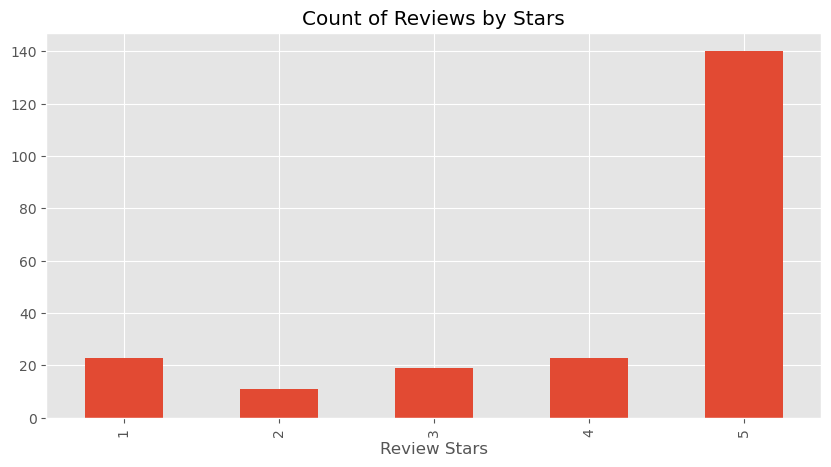

In [17]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [29]:
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SHALBIN\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\SHALBIN\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\SHALBIN\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [22]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [23]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [24]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [30]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


#  VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [31]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [32]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [33]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [34]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [35]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/216 [00:00<?, ?it/s]

In [36]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [37]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulness_Ratio,Cleaned_Summary,Cleaned_Text,Sentiment,Normalized_Helpfulness
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,good quality dog food,bought several vitality canned dog food produc...,Positive,1.0
1,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,delight say,confection around century light pillowy citrus...,Positive,1.0
2,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,cough medicine,looking secret ingredient robitussin believe f...,Negative,1.0
3,9,0.000,0.851,0.149,0.6369,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...,1.0,yay barley,right im mostly sprouting cat eat grass love r...,Positive,1.0
4,11,0.017,0.846,0.137,0.9746,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1.0,best hot sauce world,dont know cactus tequila unique combination in...,Positive,1.0


## Plot VADER results

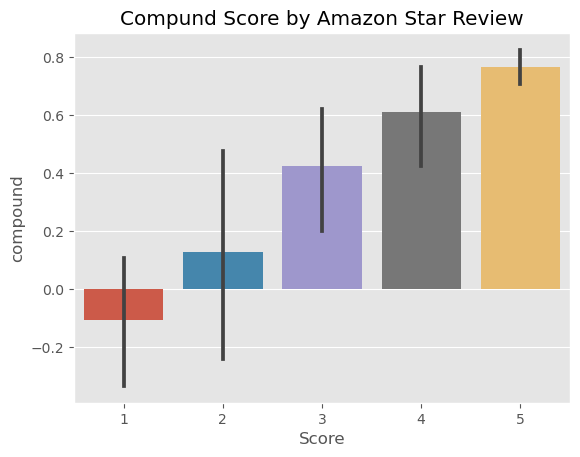

In [38]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

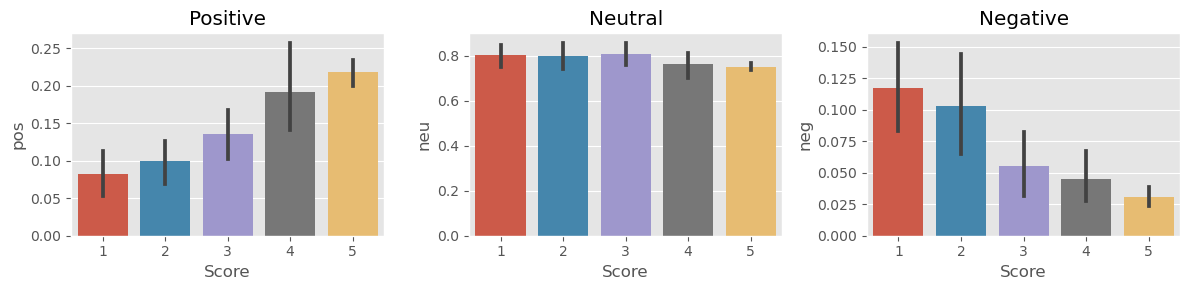

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [40]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [41]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [42]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [43]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [44]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [45]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/216 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [46]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [47]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text', 'Helpfulness_Ratio',
       'Cleaned_Summary', 'Cleaned_Text', 'Sentiment',
       'Normalized_Helpfulness'],
      dtype='object')

# Step 3. Combine and compare

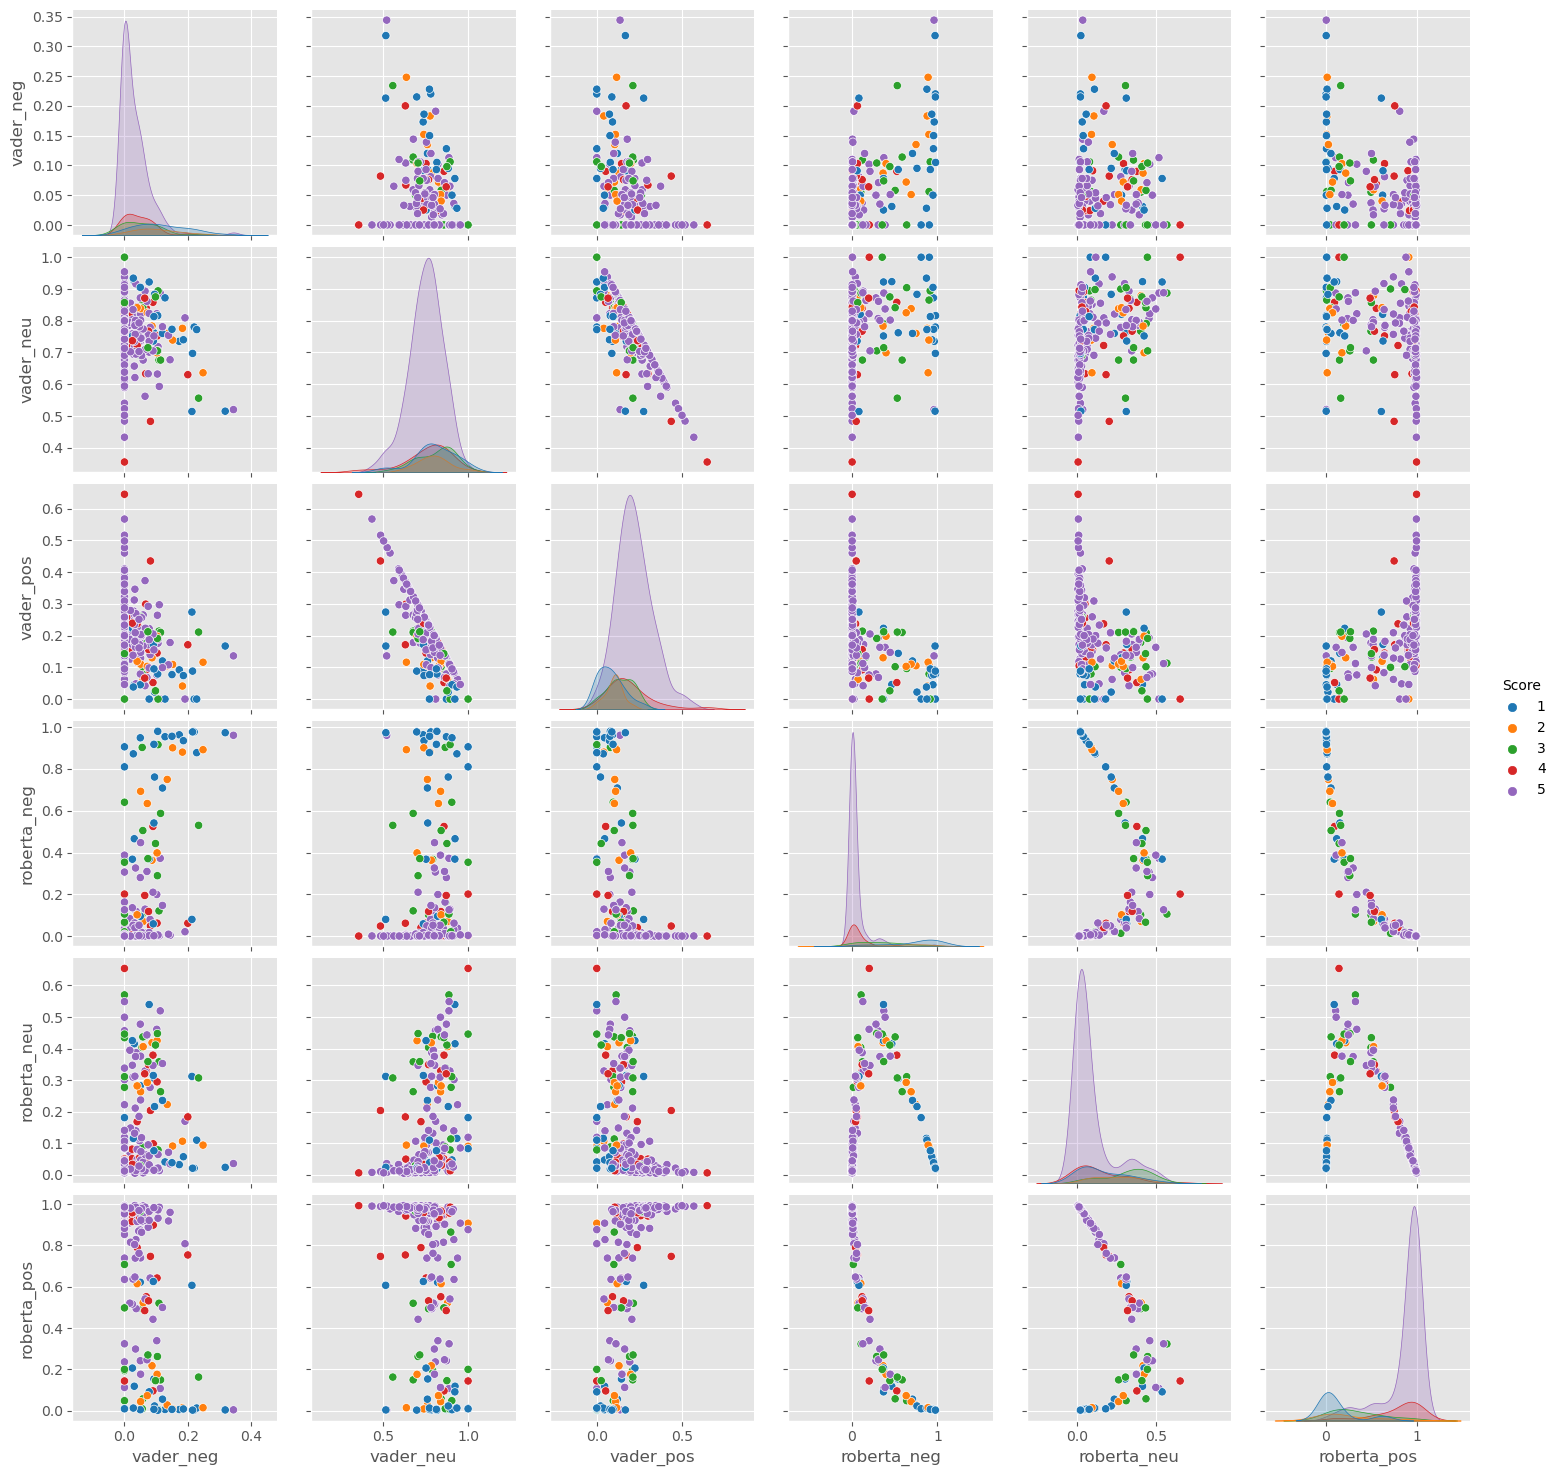

In [48]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [49]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [50]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [51]:
# nevative sentiment 5-Star view

In [52]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [53]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [32]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [33]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [34]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [35]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

# The End